<a href="https://colab.research.google.com/github/tombackert/CS411-ml-for-ds/blob/main/CSUPERB_Transfer_Learning_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Transfer Learning for Biomedical Image Data

In biomedical, the task of predicting a condition from image data is highly important to diagnose a variety of medical conditions. In computer science, this task is called image classification. Algorithmic image classification is usually performed using a specific type of algorithm called deep learning. Deep learning is a subset of machine learning, in which the algorithm is trained using data.

In image classification using deep learning, the workflow usually goes as follows:

1. Create a dataset with a folder for each class of image.
2. Split this dataset into training, validation, and testing sets.
3. Train the model using the training set.
4. Optimize the training parameters using the validation set.
5. Evaluate the model using the testing set.


Deep learning has been successfully used to accurately classify many types of biomedical images. Very recently, a classification algorithm was able to detect breast cancer from mammography images with an accuracy of 98% [[1]](https://www.nature.com/articles/s41598-019-48995-4). In collaboration with Dr Ilmi Yoon, Domingo Lab and her graduate students, the accuracy of the classification of images of tadpole (frog) embryos stained with muscle and intersomitic boundaries was improved using deep transfer learning. These images were classified into two categories: control and mutant. This notebook outlines the core algorithm used for this task in a general way, so that future experiments with novel datasets can easily be conducted.



## Background

Before any code is run, it is important to understand some basics of neural networks and transfer learning.


### Deep Neural Networks
A deep neural network is a conditional probability estimator which can predict the probability of some condition given some input. This makes it useful for image classification, which involves detecting the probability of a condition once provided with an image. This project an industry standard neural network architecture called VGG16 (see image), which accepts color images as input and predicts the probability that the image belongs to any of 1000 general image classes.

![VGG16 Architecture](https://miro.medium.com/max/470/1*3-TqqkRQ4rWLOMX-gvkYwA.png)


This network is composed of many network layers. Each layer further processes the image. The output layer is the orange block at the end of the network, which outputs the probability distribution among the image classes.


### Transfer Learning
While Deep Learning has advanced recognition of patterns and understanding of data in various formats, recent advancements in Convolution Neural Network (CNN) achieve super-human level computer vision in natural photo images [3]. Typical human error in image recognition is 5% while the latest CNN models such as VGG19, Inception achieves 3% or lower rates [4]. These achievements are made with advanced Convolution Neural Network (CNN) architecture design, careful selection of hyperparameters, the large and good data set (more than 15 million labeled images) and high computation power for long deep learning training; typical computer science lab will have difficulty in achieving the same results. Fortunately, to promote the advancement of deep learning applications, Google, Oxford research group or other most advanced researchers made their fully trained CNN publicly available through “Transfer Learning” technology [4]. However, these fully trained CNN are trained with objects naturally found from photo images such as dog, cat, car, etc. Scientists or domain experts have started to utilize these fully-trained-CNN to classify their scientific data with small additional training process (called fine-tuning).
Transfer learning is the process fine-tuning a well trained neural network (like VGG16) for a specific task. This has been proven to be effective at classifying medical image data with minimal training time and smaller datasets than would otherwise be required for high levels of accuracy. The output layer  with 1000 classes is replaced with a custom layer with the number of outputs equal to the number of classes of image we have. In this project, the classes are control and mutant. The network is then retrained with a small hand-labeled dataset.

## Introduction to Colab Notebooks

### Running a Code Cell

The cell below is written in python code. In order to execute a cell, press the play button next to the cell, or press Shift-Enter while within a code cell. The output generated by a cell will be shown below the cell. Try executing the cell below.

In [ ]:
print('Hello World')


Hello World


The output should read 'Hello World'.


### Configuring the Virtual Interpreter
The colab environment runs code cells on a virtual cloud computer owned by Google. To ensure that the code is executed efficiently, GPU (graphics processing) must be enabled:

* Navigate to 'Runtime' > 'Change Runtime Type'
* Ensure that 'Hardware Accelerator' is set to 'GPU'

Once you have performed these steps, the output of the code cell below should read 'GPU 0' followed by the name of the graphics processor.

In [1]:
!nvidia-smi --list-gpus

/bin/bash: line 1: nvidia-smi: command not found


### Importing the Software Libraries

The following code imports some software libraries necessary to execute the project.

In [2]:
%tensorflow_version 2.x
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
print("Import Success!")

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Import Success!


## Working with Training Data

The data must be loaded into the Keras API (a software library) so that it can be easily fed to the machine learning model.


### Downloading the Data
First, the data must be downloaded to the virtual machine.

In [3]:
!pip install gdown
import gdown
url = 'https://drive.google.com/uc?id=14bW8k2QYj7aR9-YZL9vVg2FqqfbylvZS'
output = 'cropdata.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=14bW8k2QYj7aR9-YZL9vVg2FqqfbylvZS
From (redirected): https://drive.google.com/uc?id=14bW8k2QYj7aR9-YZL9vVg2FqqfbylvZS&confirm=t&uuid=62fae6fb-338b-43e2-87a1-c0b20cfe18b4
To: /content/cropdata.zip
100%|██████████| 75.1M/75.1M [00:00<00:00, 84.1MB/s]


'cropdata.zip'

### Extract the Data

Since the images are in a .zip file, they must first be extracted to .jpg images.


In [4]:
!unzip cropdata.zip
print("Done.")

Archive:  cropdata.zip
   creating: cropdata/
   creating: cropdata/valid/
  inflating: cropdata/.DS_Store      
  inflating: __MACOSX/cropdata/._.DS_Store  
   creating: cropdata/test/
   creating: cropdata/train/
  inflating: cropdata/valid/.DS_Store  
  inflating: __MACOSX/cropdata/valid/._.DS_Store  
   creating: cropdata/valid/mutant/
   creating: cropdata/valid/control/
  inflating: cropdata/test/.DS_Store  
  inflating: __MACOSX/cropdata/test/._.DS_Store  
   creating: cropdata/test/mutant/
   creating: cropdata/test/control/
  inflating: cropdata/train/.DS_Store  
  inflating: __MACOSX/cropdata/train/._.DS_Store  
   creating: cropdata/train/mutant/
   creating: cropdata/train/control/
  inflating: cropdata/valid/mutant/269175695.jpg  
  inflating: __MACOSX/cropdata/valid/mutant/._269175695.jpg  
  inflating: cropdata/valid/mutant/317712245.jpg  
  inflating: __MACOSX/cropdata/valid/mutant/._317712245.jpg  
  inflating: cropdata/valid/mutant/300077301.jpg  
  inflating: __MACOS

### Splitting the Dataset

The data is divided in to three sets: train, validation, and test. The training data will be used to train the model. The validation data will be run through the model occationally to ensure that it is generalizing well to input outside the training cases (not overfitting). The validation data is used to determine the optimal amount of training. The test data will be kept until training is completely done in order to measure our peformance.

In [5]:
train_path = 'cropdata/train'
valid_path = 'cropdata/valid'
test_path = 'cropdata/test'
print("Paths Loaded.")

Paths Loaded.


### Creating the Data Generators

The model requires the image to be provided as batches of image vectors. By batch, we just mean a consistent number of images. A useful software interface for feeding data into our model is an ImageDataGenerator from the Keras library.  After specifying the data source and other parameters, it will continually generate data batches of specified size for our model to use.

In [6]:
image_size = (224, 224)
classes = ['control', 'mutant']
print("Training:")
train_batches = ImageDataGenerator() \
                  .flow_from_directory(train_path,
                                       image_size,
                                       classes=classes,
                                       batch_size=15)
print("Validation:")
valid_batches = ImageDataGenerator() \
                  .flow_from_directory(valid_path,
                                       image_size,
                                       classes=classes,
                                       batch_size=5)
print("Testing:")
test_batches = ImageDataGenerator() \
                .flow_from_directory(test_path,
                                     image_size,
                                     classes=classes,
                                     batch_size=64)

Training:
Found 454 images belonging to 2 classes.
Validation:
Found 113 images belonging to 2 classes.
Testing:
Found 189 images belonging to 2 classes.


### Visualizing the Data

The following code will display some of the training images so we can see what they look like.

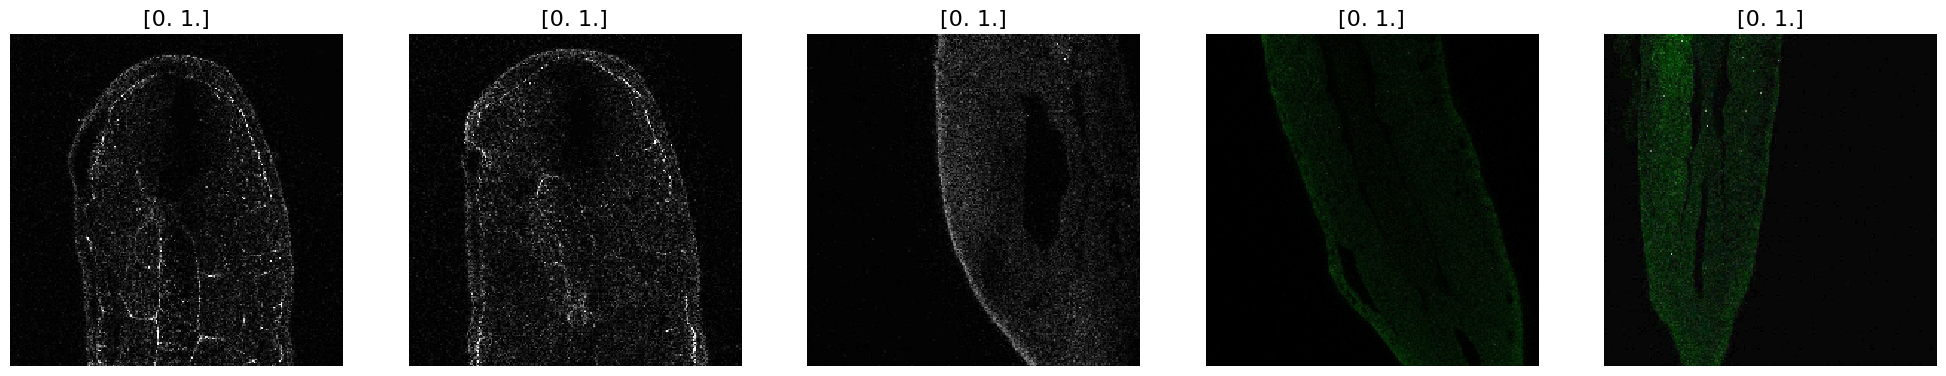

In [7]:
# plots images with labels
def plots(ims, figsize=(30,30), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

imgs, labels = next(train_batches)

plots(imgs[0:5], titles=labels)

## Creating the Model

In Keras, the deep learning model is represented by layers of processing.
After importing a pretrained model, a new model is created using this model. All of these layers are copied from the pretrained model to the new model. However, the final output layer will be replaced and retrained using the labeled data, esssentially customizing the output for this specific classification task.

### Loading a Pretrained Model

A pretrained VGG16 model is downloaded using the Keras library.

In [ ]:
vgg16_model = tensorflow.keras.applications.VGG16()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
vgg16_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

### Creating a Custom Output Model#

A new model is created copying all layers except the output layer. Notice that these layers are set to be non-trainable. Finally, a custom output layer is added to the model.  This output layer should have the same number of outputs as the number of different classes of data. The softmax activation function conditions the output to be a probability distribuiton adding up to unity.
In mathematics, the softmax function, also known as softargmax or normalized exponential function, is a function that takes as input a vector of K real numbers, and normalizes it into a probability distribution consisting of K probabilities proportional to the exponentials of the input numbers.
Therefore, our model will output a probability distribution among the classes as output for each input image.

In [8]:
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout

In [ ]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
for layer in model.layers:
    layer.trainable = False

model = Sequential([
    model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(64, activation='relu'),
    Dropout(rate=0.25),
    Dense(len(classes), activation='softmax')
])

In [20]:
vgg19_model = tensorflow.keras.applications.VGG19()

574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [21]:


model = Sequential([
    vgg19_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(2, activation='softmax')
])

In [22]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 1000)                │     143,667,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         128,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 143,795,626 (548.54 MB)

 Trainable params: 143,795,626 (548.54 MB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

Now that the model has been specified, it must be trained to detect mutated frog images.




### Compiling the Model
In preperation for training, the model is compiled. In order to train it, we must evaluate its performance using a loss function. This function is designed to increase as performance decreases. Therefore, in training, we are essentially minimizing the value of the loss function. Since we are predicting a condition (yes/no), we are using cross-entropy, which is a concept from information theory. If we were instead predicting a numerical value, the correct loss function would be 'mean_squared_error'.

In [23]:
#model.compile(Adam(lr=.1),
model.compile(Adam(learning_rate=.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print("Done")

Done


### Minimizing Loss

The model is now trained using the backpropagation algorithm to minimize the loss function. The training data will be passed into the model and evaluated using the loss function. Then, the model will be adjusted to decrease the loss.

Here we specifiy the epochs, which is the number of times we pass through the entire training set. These specifications are determined by experimentation with the goal of minimizing validation loss. If the epochs are too high, the model has overfit to the data (too specific). If the epochs are too low, the model has underfit to the data (too general). The validation loss must be compared to training loss to determine if the model is optimally fit to the data.


In [ ]:
num_epochs = 20
history = model.fit(
     train_batches,
     steps_per_epoch = train_batches.samples // 15,
     validation_data = valid_batches,
     validation_steps = valid_batches.samples // 5,
     epochs=num_epochs,
     verbose=1)
print("Trining Complete!")

Epoch 1/20


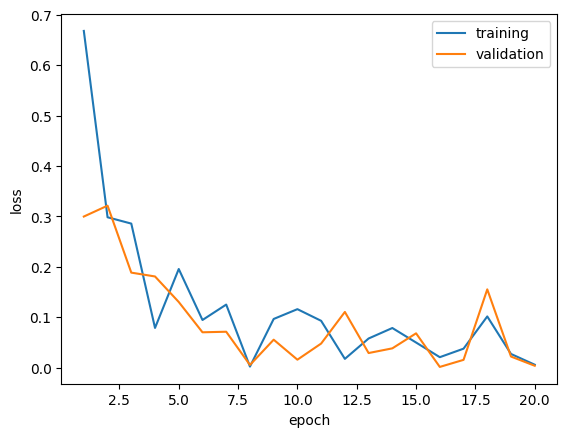

In [ ]:
#plot loss history
epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## Testing the Model

To perform a final test of the model, the test data is fed through the model.  It is important to use data what was removed from the training set so we can test the performance accurately. The accuracy (percentage of images classified correctly) is calculated and a confusion matrix is generated.

### Test Accuracy

To calculate accuracy, the model is evaluated using the test generator specified earlier.

In [ ]:
test_batches = ImageDataGenerator() \
                .flow_from_directory(test_path,
                                     image_size,
                                     classes=classes,
                                     batch_size=189)
test_loss, test_acc = model.evaluate(test_batches,
                                     steps=3,
                                     verbose=0)
print(test_loss)
print(test_acc)

Found 189 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


0.032779645174741745
0.9894179701805115


/usr/local/lib/python3.10/dist-packages/PIL/Image.py
/usr/local/lib/python3.10/dist-packages/PIL/Image.py


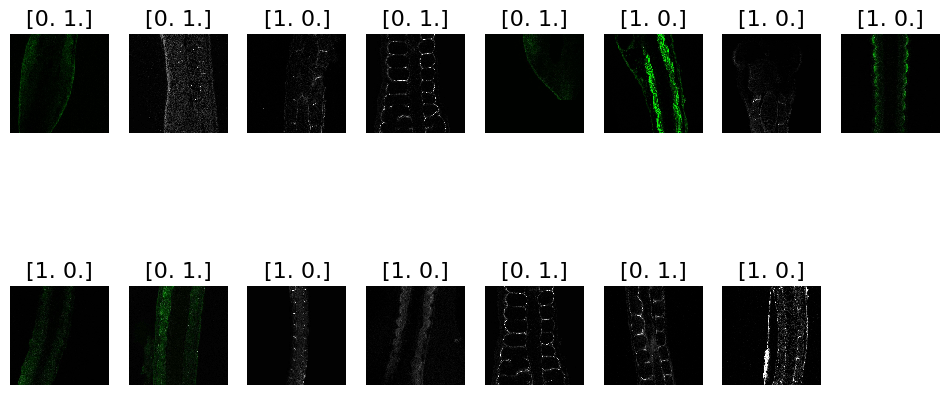

In [ ]:
#show images
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

import sys
from PIL import Image
sys.modules['Image'] = Image
print(Image.__file__)
import Image
print(Image.__file__)

test_imgs, test_lables = next(train_batches)
plots(test_imgs, titles=test_lables, rows=2)

### Confusion Matrix

A confusion matrix gives more insight than just accuracy: It indicates which images were classified correctly, and for the incorrect ones, it indicates how (mutant instead of control vs. control instead of mutant). It allows us to determine which classes the model performed well on and which classes the model performed poorly on. If a model performs poorly on a specific class, it may be cauesed by an unclean dataset or insufficient quanitity of images of that class.

[1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1.
 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1.]
Confusion matrix, without normalization
[[102   0]
 [  2  85]]


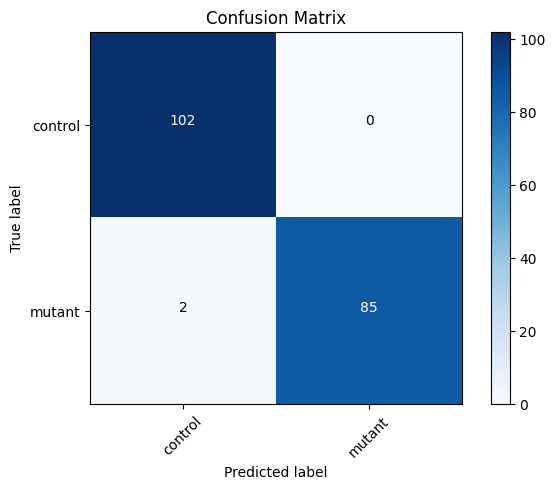

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

test_batches.reset()
test_imgs, test_labels = next(test_batches)
test_labels = test_labels[:,0]
predictions = model.predict(test_batches, steps=1, verbose=0)
print(np.round(predictions[:,0]))
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

cm_plot_labels = ['control','mutant']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')


## Saving the fine-tuned VGG16 model

Now that the model has been trained and tested, it should be saved so we can classify new images without retraining.

In [ ]:
model.save('fineTunedVGG16.h5')
print("Model Saved.")

Model Saved.


## Loading the fine-tuned VGG16 model

In a production environment, the model should be loaded without repeating the training process.

## Conclusion

In this notebook, using transfer learning for image classification has been demonstrated. First, the data is uploaded and connected to the Keras API. Then, the model is defined by copying a pretrained model and adding a new output layer. Once defined, the model can be trained using the appropriate loss function. Finally, the model is evaluated using a test dataset. With minimal modification, the model can be used to predict more than two classes and scalar values. It is encouraged to use this notebook as a templete for similar models using novel datasets.